In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import KMeansSMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report
from util.get_data import get_features_and_targets, dense_transform
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from imblearn.pipeline import Pipeline as ImbPipeline

In [3]:
X, y = get_features_and_targets()

GENDER column transformed: [1 0]
EDUCATION_LEVEL column transformed: [2 1 3 4]
MARITAL_STATUS column transformed: [1 2 3]
CREDIT_LIMIT: 167 outliers capped.
AGE: 272 outliers capped.
SEPT_BILL: 2400 outliers capped.
AUG_BILL: 2395 outliers capped.
JULY_BILL: 2469 outliers capped.
JUNE_BILL: 2622 outliers capped.
MAY_BILL: 2725 outliers capped.
APRIL_BILL: 2693 outliers capped.
SEPT_PAYMENT: 2745 outliers capped.
AUG_PAYMENT: 2714 outliers capped.
JULY_PAYMENT: 2598 outliers capped.
JUNE_PAYMENT: 2994 outliers capped.
MAY_PAYMENT: 2945 outliers capped.
APRIL_PAYMENT: 2958 outliers capped.


In [19]:
categorical_features = ["GENDER", "EDUCATION_LEVEL", "MARITAL_STATUS", "SEPT_PAY_STATUS", "AUG_PAY_STATUS", "JULY_PAY_STATUS", "JUNE_PAY_STATUS", "MAY_PAY_STATUS", "APRIL_PAY_STATUS"]
numeric_features = ["AGE", "CREDIT_LIMIT", "JUNE_BILL", "MAY_BILL", "APRIL_BILL", "SEPT_PAYMENT", "AUG_PAYMENT", "JULY_PAYMENT", "JUNE_PAYMENT", "MAY_PAYMENT", "APRIL_PAYMENT"]

In [20]:
# Define the transformation for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Define the transformation for categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Ensure output is dense
])

# Combine transformations into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ], sparse_threshold=0)  # Ensures combined output is dense

# Build the pipeline
pipeline_gnb = ImbPipeline([
    ('preprocessor', preprocessor),
    ('to_dense', FunctionTransformer(dense_transform, accept_sparse=True)),  # Ensures data is dense
    ('smote', KMeansSMOTE(random_state=0, k_neighbors=5, cluster_balance_threshold=0.1)),
    ('classifier', GaussianNB())
])

# Now perform your train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and score the pipeline
pipeline_gnb.fit(X_train, y_train)
score = pipeline_gnb.score(X_test, y_test)
print(f"Accuracy of GaussianNB model: {score}")


Accuracy of GaussianNB model: 0.811


/opt/anaconda3/envs/credit_card_defaults_prediction/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [21]:
# Pipeline components for GaussianNB
numeric_transformer_gnb = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor_gnb = ColumnTransformer([
    ('num', numeric_transformer_gnb, numeric_features)
], remainder='drop')  # Drop categorical features for GaussianNB

pipeline_gnb = ImbPipeline([
    ('preprocessor', preprocessor),
    ('to_dense', FunctionTransformer(dense_transform, accept_sparse=True)),  # Ensures data is dense
    ('smote', KMeansSMOTE(random_state=0, k_neighbors=5, cluster_balance_threshold=0.1)),
    ('classifier', GaussianNB())
])

In [22]:
# Pipeline components for MultinomialNB
categorical_transformer_mnb = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Dense output for compatibility with SMOTE
])

preprocessor_mnb = ColumnTransformer([
    ('cat', categorical_transformer_mnb, categorical_features)
], remainder='drop')  # Drop numeric features for MultinomialNB

pipeline_mnb = ImbPipeline([
    ('preprocessor', preprocessor_mnb),
    ('smote', KMeansSMOTE(random_state=0)),
    ('classifier', MultinomialNB())
])


In [23]:
from sklearn.model_selection import train_test_split

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train both pipelines
pipeline_gnb.fit(X_train, y_train)
pipeline_mnb.fit(X_train, y_train)


/opt/anaconda3/envs/credit_card_defaults_prediction/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/credit_card_defaults_prediction/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GENDER', 'EDUCATION_LEVEL',
                                                   'MARITAL_STATUS',
                                                   'SEPT_PAY_STATUS',
                                                   'AUG_PAY_STATUS',
                                                   'JULY_PAY_STATUS',
                                                   'JUNE_PAY_STATUS',
                                                   'MAY_PAY_STATUS',
                                                   'APRIL_PAY_STATUS'])])),
                ('smote', KMeansSMOTE(random_state=0)),
                ('classifier', MultinomialNB())])

Accuracy of GaussianNB: 0.811
Accuracy of MultinomialNB: 0.7993333333333333
Combined Accuracy of GaussianNB and MultinomialNB: 0.812


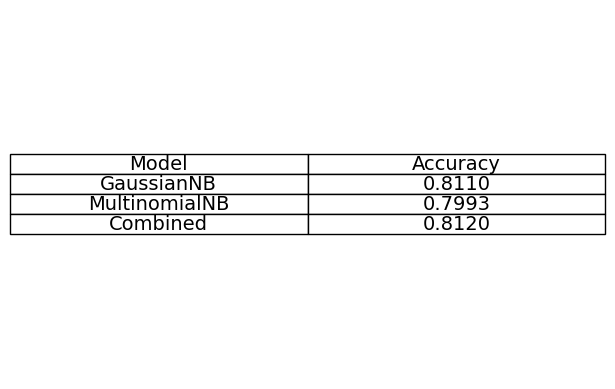

In [29]:
# Get probability predictions
probs_gnb = pipeline_gnb.predict_proba(X_test)
probs_mnb = pipeline_mnb.predict_proba(X_test)

# Average the probabilities from both models
avg_probs = (probs_gnb + probs_mnb) / 2
final_predictions = np.argmax(avg_probs, axis=1)

accuracy_gnb = accuracy_score(y_test, probs_gnb.argmax(axis=1))
accuracy_mnb = accuracy_score(y_test, probs_mnb.argmax(axis=1))
accuracy = accuracy_score(y_test, final_predictions)

print(f"Accuracy of GaussianNB: {accuracy_gnb}")
print(f"Accuracy of MultinomialNB: {accuracy_mnb}")
print(f"Combined Accuracy of GaussianNB and MultinomialNB: {accuracy}")

# Plot the accuracies as text
fig, ax = plt.subplots()
ax.axis('off')
table_data = [
    ["GaussianNB", f"{accuracy_gnb:.4f}"],
    ["MultinomialNB", f"{accuracy_mnb:.4f}"],
    ["Combined", f"{accuracy:.4f}"]
]
table = ax.table(cellText=table_data, colLabels=["Model", "Accuracy"], cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.2, 1.2)
plt.show()


#### Next, attempting predictions using KFold cross-validation

In [30]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)

# Initialize lists to store indices for each fold
train_indices = []
validation_indices = []

# Split data into folds
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    train_indices.append(train_idx)
    validation_indices.append(val_idx)

In [ ]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Store scores for averaging
train_scores = []
validation_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\nFold {fold + 1}/{n_splits}")

    # Split dataset into training and validation sets
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Ensure y_train and y_val are 1-dimensional if y is a DataFrame with a single target column
    # These will convert DataFrame columns to 1D numpy arrays
    y_train = y_train.squeeze().values
    y_val = y_val.squeeze().values

    # Fit both pipelines on the training data
    pipeline_gnb.fit(X_train, y_train)
    pipeline_mnb.fit(X_train, y_train)

    # Predict on the training data
    y_train_pred_gnb = pipeline_gnb.predict(X_train)
    y_train_pred_mnb = pipeline_mnb.predict(X_train)

    # Average the training predictions
    avg_train_predictions = (y_train_pred_gnb + y_train_pred_mnb) / 2
    avg_train_predictions = np.round(avg_train_predictions).astype(int)  # Convert averages to discrete class predictions

    # Compute training accuracy
    train_accuracy = accuracy_score(y_train, avg_train_predictions)
    train_scores.append(train_accuracy)

    # Predict probabilities on the validation set and combine predictions
    probs_gnb = pipeline_gnb.predict_proba(X_val)
    probs_mnb = pipeline_mnb.predict_proba(X_val)
    avg_probs = (probs_gnb + probs_mnb) / 2
    final_predictions = np.argmax(avg_probs, axis=1)

    # Compute and append validation accuracy
    validation_accuracy = accuracy_score(y_val, final_predictions)
    validation_scores.append(validation_accuracy)

    print(f"Training Accuracy for current fold: {train_accuracy:.2f}")
    print(f"Validation Accuracy for current fold: {validation_accuracy:.2f}")

# Calculate average scores across all folds
average_train_score = np.mean(train_scores)
average_val_score = np.mean(validation_scores)

print("\nK-Fold Cross-Validation Results for Ensemble Naive Bayes Model:")
print(f"Average Training Accuracy: {average_train_score:.2f}")
print(f"Average Validation Accuracy: {average_val_score:.2f}")



Fold 1/5
Training Accuracy for current fold: 0.80
Validation Accuracy for current fold: 0.80

Fold 2/5
Training Accuracy for current fold: 0.81
Validation Accuracy for current fold: 0.81

Fold 3/5
Training Accuracy for current fold: 0.80
Validation Accuracy for current fold: 0.82

Fold 4/5
Training Accuracy for current fold: 0.80
Validation Accuracy for current fold: 0.79

Fold 5/5
Training Accuracy for current fold: 0.81
Validation Accuracy for current fold: 0.81

K-Fold Cross-Validation Results for Ensemble Naive Bayes Model:
Average Training Accuracy: 0.80
Average Validation Accuracy: 0.81


In [14]:
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import KFold

# Assuming X and y are the complete datasets
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Store scores for averaging
gnb_train_scores = []
gnb_validation_scores = []
mnb_train_scores = []
mnb_validation_scores = []

ensemble_train_scores = []
ensemble_validation_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\nFold {fold + 1}/{n_splits}")

    # Split dataset into training and validation sets
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx].squeeze().values, y.iloc[val_idx].squeeze().values

    # Fit both pipelines on the training data
    pipeline_gnb.fit(X_train, y_train)
    pipeline_mnb.fit(X_train, y_train)

    # Predict on the training data
    y_train_pred_gnb = pipeline_gnb.predict(X_train)
    y_train_pred_mnb = pipeline_mnb.predict(X_train)

    # Calculate individual training accuracies
    gnb_train_accuracy = accuracy_score(y_train, y_train_pred_gnb)
    mnb_train_accuracy = accuracy_score(y_train, y_train_pred_mnb)
    gnb_train_scores.append(gnb_train_accuracy)
    mnb_train_scores.append(mnb_train_accuracy)

    # Average the training predictions for ensemble
    avg_train_predictions = (y_train_pred_gnb + y_train_pred_mnb) / 2
    avg_train_predictions = np.round(avg_train_predictions).astype(int)
    ensemble_train_accuracy = accuracy_score(y_train, avg_train_predictions)
    ensemble_train_scores.append(ensemble_train_accuracy)

    # Predict probabilities on the validation set
    probs_gnb = pipeline_gnb.predict_proba(X_val)
    probs_mnb = pipeline_mnb.predict_proba(X_val)
    
    # Calculate individual validation accuracies
    y_val_pred_gnb = np.argmax(probs_gnb, axis=1)
    y_val_pred_mnb = np.argmax(probs_mnb, axis=1)
    gnb_val_accuracy = accuracy_score(y_val, y_val_pred_gnb)
    mnb_val_accuracy = accuracy_score(y_val, y_val_pred_mnb)
    gnb_validation_scores.append(gnb_val_accuracy)
    mnb_validation_scores.append(mnb_val_accuracy)
    
    # Average the validation probabilities for ensemble
    avg_probs = (probs_gnb + probs_mnb) / 2
    final_predictions = np.argmax(avg_probs, axis=1)
    ensemble_validation_accuracy = accuracy_score(y_val, final_predictions)
    ensemble_validation_scores.append(ensemble_validation_accuracy)

    # Output fold results
    print(f"GNB Training Accuracy: {gnb_train_accuracy:.2f}, Validation Accuracy: {gnb_val_accuracy:.2f}")
    print(f"MNB Training Accuracy: {mnb_train_accuracy:.2f}, Validation Accuracy: {mnb_val_accuracy:.2f}")
    print(f"Ensemble Training Accuracy: {ensemble_train_accuracy:.2f}, Validation Accuracy: {ensemble_validation_accuracy:.2f}")

# Calculate average scores across all folds
average_gnb_train = np.mean(gnb_train_scores)
average_gnb_val = np.mean(gnb_validation_scores)
average_mnb_train = np.mean(mnb_train_scores)
average_mnb_val = np.mean(mnb_validation_scores)

average_ensemble_train = np.mean(ensemble_train_scores)
average_ensemble_val = np.mean(ensemble_validation_scores)

print("\nFinal K-Fold Cross-Validation Results:")
print(f"GNB Average Training Accuracy: {average_gnb_train:.2f}, Average Validation Accuracy: {average_gnb_val:.2f}")
print(f"MNB Average Training Accuracy: {average_mnb_train:.2f}, Average Validation Accuracy: {average_mnb_val:.2f}")
print(f"Ensemble Average Training Accuracy: {average_ensemble_train:.2f}, Average Validation Accuracy: {average_ensemble_val:.2f}")



Fold 1/5
GNB Training Accuracy: 0.80, Validation Accuracy: 0.80
MNB Training Accuracy: 0.80, Validation Accuracy: 0.80
Ensemble Training Accuracy: 0.80, Validation Accuracy: 0.80

Fold 2/5
GNB Training Accuracy: 0.81, Validation Accuracy: 0.81
MNB Training Accuracy: 0.80, Validation Accuracy: 0.80
Ensemble Training Accuracy: 0.81, Validation Accuracy: 0.81

Fold 3/5
GNB Training Accuracy: 0.80, Validation Accuracy: 0.81
MNB Training Accuracy: 0.80, Validation Accuracy: 0.82
Ensemble Training Accuracy: 0.80, Validation Accuracy: 0.82

Fold 4/5
GNB Training Accuracy: 0.80, Validation Accuracy: 0.79
MNB Training Accuracy: 0.80, Validation Accuracy: 0.80
Ensemble Training Accuracy: 0.80, Validation Accuracy: 0.79

Fold 5/5
GNB Training Accuracy: 0.81, Validation Accuracy: 0.80
MNB Training Accuracy: 0.81, Validation Accuracy: 0.80
Ensemble Training Accuracy: 0.81, Validation Accuracy: 0.81

Final K-Fold Cross-Validation Results:
GNB Average Training Accuracy: 0.80, Average Validation Accu

In [15]:
# Use a VotingClassifier to combine the two models
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

# Define the ensemble model
ensemble = VotingClassifier(
    estimators=[("gnb", pipeline_gnb), ("mnb", pipeline_mnb)],
    voting="soft",
    weights=[1, 1],
)

n_splits = 2

for fold in range(1, n_splits + 1):
    print(f"\nFold {fold}/{n_splits}")

    # Split dataset into training and validation sets
    X_train, X_val = (
        X.iloc[train_indices[fold - 1]],
        X.iloc[validation_indices[fold - 1]],
    )
    y_train, y_val = (
        y.iloc[train_indices[fold - 1]].squeeze().values,
        y.iloc[validation_indices[fold - 1]].squeeze().values,
    )

    # Fit the ensemble model on the training data
    ensemble.fit(X_train, y_train)

    # Evaluate the ensemble model on the validation data
    val_score = ensemble.score(X_val, y_val)
    print(f"Validation Accuracy: {val_score:.2f}")

    # Perform k-fold cross-validation on the ensemble model
    cv_scores = cross_val_score(ensemble, X, y.squeeze().values, cv=kf)
    avg_cv_score = np.mean(cv_scores)
    print(f"Average Cross-Validation Accuracy: {avg_cv_score:.2f}")
    print(f"Cross-Validation Scores: {cv_scores}")
    # classification report
    y_pred = ensemble.predict(X_val)
    print("Classification Report:")
    print(classification_report(y_val, y_pred))

# Train a new ensemble model without k-fold cross-validation for comparison
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit the ensemble model on the training data
ensemble.fit(X_train, y_train)

# Evaluate the ensemble model on the test data
test_score = ensemble.score(X_test, y_test)
print(f"Test Accuracy without K-Fold: {test_score:.2f}")

# Generate classification report
y_pred = ensemble.predict(X_test)
print("Classification Report without K-Fold:")
print(classification_report(y_test, y_pred))


Fold 1/2
Validation Accuracy: 0.82
Average Cross-Validation Accuracy: 0.81
Cross-Validation Scores: [0.80483333 0.8065     0.817      0.792      0.806     ]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4703
           1       0.64      0.34      0.44      1297

    accuracy                           0.82      6000
   macro avg       0.74      0.64      0.67      6000
weighted avg       0.80      0.82      0.79      6000


Fold 2/2
Validation Accuracy: 0.80
Average Cross-Validation Accuracy: 0.81
Cross-Validation Scores: [0.80483333 0.8065     0.817      0.792      0.806     ]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.97      0.88      4705
           1       0.62      0.19      0.29      1295

    accuracy                           0.80      6000
   macro avg       0.72      0.58      0.59      6000
weighted avg       0.77      0.80      

/opt/anaconda3/envs/credit_card_defaults_prediction/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/credit_card_defaults_prediction/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Test Accuracy without K-Fold: 0.81
Classification Report without K-Fold:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4687
           1       0.63      0.35      0.45      1313

    accuracy                           0.81      6000
   macro avg       0.73      0.65      0.67      6000
weighted avg       0.79      0.81      0.79      6000



In [16]:
# import joblib

# # Save the best model to a file
# joblib.dump(ensemble, 'models/naive_bayes/naive_bayes_ensemble.joblib')

# # Save test features and targets for the model
# joblib.dump(X_test, 'models/naive_bayes/test_features.joblib')
# joblib.dump(y_test, 'models/naive_bayes/test_targets.joblib')

['models/naive_bayes/test_targets.joblib']